**Introduction**

In this method for image classification using the MNIST dataset, we look at classification using different Linear Regression (LR) and Multi-Layer Perceptron (MLP) neural network models.

The following notebook will compare 3 package libraries, indcluing:
1. SKLearn
2. Pytorch
3. Tensorflow

With these 3 libraries, we will compare the accuracy, loss, complexity, and amount of time it takes to train the models, to determine the best/most efficient library for image classification with LR and MLP models.


**1. The Dataset**

The first step is to import and manipulate the dataset for use in our models. We will import the dataset using the pandas library, split the dataset into train and test sets using sklearn's train_test_split, and normalize the data with a function we will create.
We are also importing mathplotlib for plotting results, numpy, and datetime.

The dataset is the 'train.csv' MNIST dataset from Kaggle competition DIGIT Recognizer found here:

https://www.kaggle.com/c/digit-recognizer/data

The Dataset has 42,000 rows and 785 columns, with 784 features (values 0-255) and 1 label (values 0-9).


**Note that we are only using the train.csv from the kaggle dataset, since their provided test.csv does not contain labels**

To start, we are only going to use the first 10000 samples of the dataset to speed up initial training and comparison of models. We will train the best/fastest models on the entire dataset later in the notebook.

In [1]:
#Import libraries for reading dataset and other libraries used later on
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import datetime

#For Google colab, import the train.csv file
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
#Read the dataset
train = pd.read_csv("train.csv")
#Split features and labels
X = train.iloc[:10000, 1:]
y = train.iloc[:10000, 0]
#X = train.iloc[:, 1:]
#y = train.iloc[:, 0]
#Use train_test_split to split to train/test labels and train/test features. Train size = 70%, Test size = 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

#Print sizes
print('Train features: ',X_train.shape,', Train Labels: ',y_train.shape)
print('Test features: ',X_test.shape,', Test Labels: ',y_test.shape)

Train features:  (7000, 784) , Train Labels:  (7000,)
Test features:  (3000, 784) , Test Labels:  (3000,)


Next, we normalize the data by coverting the images from gray-scale to black and white. This is done by dividing each pixel by 255 and rounding to either 0 or 1. Pixels with values less than 127.5 will become 0, and values greater will become 1. This is to simplify the one-hot process.

In [0]:
#function to convert grayscal to black and white
#format data ONLY RUN ONCE
def format_data(x):
    return int(round(x/255))
X_train = X_train.applymap(format_data)
X_test = X_test.applymap(format_data)

Plotting class distribution across labels shows that labels are fairly represented.

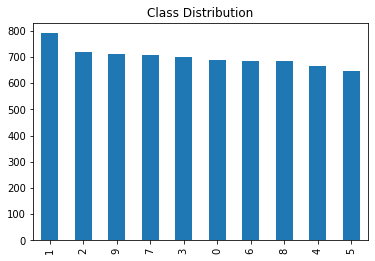

In [0]:
#Show distribution of each class
plt.figure() # Creates a new figure
y_train.value_counts().plot(kind="bar", title="Class Distribution")
plt.show()

**2. SKLearn LR and MLP**

In this step, we create LR and MLP models using SKLearn. This will act as a baseline to compare Pytorch and Tensorflow, since SKLearn has already been covered in the notebooks for this course.

**2a. Linear Regression with SKLearn**

In [0]:
#Import Linear Regression
from sklearn.linear_model import LinearRegression
model_sklr = LinearRegression()

In [0]:
#Train the mdoel
model_sklr.fit(X_train,y_train)
#print scores
print('Train score:',model_sklr.score(X_train,y_train),', Test score:', model_sklr.score(X_test,y_test))

Train score: 0.6393655805933738 , Test score: -5.932812308119847e+20


This model performs very poorly. In terms of complexity and time cost, it is very easy to implement and is fast running; however, the training score is relatively low, and the model is extremely over-fitted to the train data, shown by the score of -593% on the test data.

**2b. MLP with SKLearn**

In [0]:
#Import MLP
from sklearn.neural_network import MLPClassifier
model_skmlp=MLPClassifier(solver='adam',hidden_layer_sizes=350,alpha=1e-08)
#Train model
model_skmlp.fit(X_train, y_train)
#Print scores
print('Train score:',model_skmlp.score(X_train,y_train),', Test score:', model_skmlp.score(X_test,y_test))

Train score: 1.0 , Test score: 0.947


This model performs fairly well. It is easy and fast to implement, and produces great scores on the training and test data. The model is over-fitted to the training data by about 5.3%, but the test data still produces a good score at 94.7%.

Since the MLP model performed better than LR model, we will use the MLP model with SKLearn to judge the performance of LR and MLP models with Pytorch and Tensorflow.

**3. PyTorch LR and MLP**

In this section, we will implement LR and MLP models with Pytorch. To start, we need to import the proper packages and convert the train/test data from numpy arrays to tensor variables.

In [0]:
#import torch packages
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

#Numpy to tensor
X_train_torch = torch.from_numpy(X_train.values)
y_train_torch = torch.from_numpy(y_train.values).type(torch.LongTensor)
X_test_torch = torch.from_numpy(X_test.values)
y_test_torch = torch.from_numpy(y_test.values).type(torch.LongTensor)

Next, we define parameters for training the data. I know from previous experience that Pytorch performs very slowly, and so I define a low number of 5 epochs and a batch size of 500. We are using a small number of epochs because, as we will see, the Pytorch models take a very long time to execute.

In [0]:
num_epochs = 5
batch_size = 500
train_size = len(X_train_torch)
n_batches=train_size//batch_size

**3a. LR with Pytorch**

First we define the LR Model. The format for defining the model is similar to the MLP model, except Linear regression only has an input/output layer and no hidden layers.

In [0]:
#Define the model
class LRModelPy(torch.nn.Module): 
    def __init__(self): 
        super(LRModelPy, self).__init__() 
        self.linear = torch.nn.Linear(28*28, 10)
  
    def forward(self, x): 
        y_pred = self.linear(x) 
        return y_pred 
model_lr_pytorch = LRModelPy() 

Here we define Cross-entropy as our loss function and Stochastic Gradient Descent as our optimizer.

In [0]:
criterion = nn.CrossEntropyLoss() 
optimizer_lr_py = torch.optim.SGD(model_lr_pytorch.parameters(), lr = 0.01)

Define lists to keep track of score and loss for epochs.

In [0]:
loss_epoch=[]
score_epoch=[]

Training the model with the train data.

optimizer_lr_py.step() performs a parameter update based on the current gradient.

loss.backward() accumulates the gradient for each parameter.

In [0]:
print('Starting at ',str(datetime.datetime.now()))
correct=0
#For num of epochs (5)
for epoch in range(num_epochs):
  score_batch=[]
  loss_batch=[] 
  #For every sample
  for i in range(train_size): 
    #Reshaping features
        images = Variable(X_train_torch.view(-1, 28 * 28)) 
        labels = Variable(y_train_torch) 
  
        # Forward + Backward + Optimize 
        optimizer_lr_py.zero_grad() 
        #Predict based on features and labels
        outputs = model_lr_pytorch(images.float()) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer_lr_py.step() 
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.data[i]
        #if prediction is correct, +1 to correct
        if(predicted==labels.data[i]):
          correct += 1

        #Calculate the score at every batch step (500)
        if (i + 1) % batch_size == 0: 
          loss_batch.append(loss.item())
          score_batch.append(correct/batch_size)
          #print('batch: [',(i+1)//500,'/',n_batches,']','loss: ',loss.item(),' score: ',correct/batch_size)
          correct=0
  score_epoch.append(sum(score_batch)/n_batches)
  loss_epoch.append(sum(loss_batch)/n_batches)
  print('Epoch: [',epoch+1,'/',num_epochs,'], avg_batch_loss: [',loss_epoch[epoch],'], avg_batch_score: [',score_epoch[epoch],']')
print('Done at ', str(datetime.datetime.now()))

Starting at  2019-12-01 18:42:16.569792
Epoch: [ 1 / 5 ], avg_batch_loss: [ 0.43791893124580383 ], avg_batch_score: [ 0.884 ]
Epoch: [ 2 / 5 ], avg_batch_loss: [ 0.3056463875940868 ], avg_batch_score: [ 0.9178571428571429 ]
Epoch: [ 3 / 5 ], avg_batch_loss: [ 0.26812206847327097 ], avg_batch_score: [ 0.9281428571428572 ]
Epoch: [ 4 / 5 ], avg_batch_loss: [ 0.24498853938920157 ], avg_batch_score: [ 0.9352857142857145 ]
Epoch: [ 5 / 5 ], avg_batch_loss: [ 0.22815307761941636 ], avg_batch_score: [ 0.9394285714285715 ]
Done at  2019-12-01 18:56:59.834206


In [0]:
#Print the Average epoch score for training
lr_py_train_acc = sum(score_epoch)/len(score_epoch)
print('Average score across epochs: ',lr_py_train_acc)

Average score across epochs:  0.9209428571428573


In [0]:
#Test the model
correct = 0
total = 0
for i in range(len(X_test_torch)): 
    images = Variable(X_test_torch.view(-1, 28 * 28)) 
    outputs = model_lr_pytorch(images.float()) 
    _, predicted = torch.max(outputs.data, 1) 
    total += y_test_torch.size(0) 
    correct += (predicted == y_test_torch).sum() 
test_score_lrpy = 100 * correct / total
  
print('Accuracy of the model on the',len(X_test_torch),' test images: % d %%' % test_score_lrpy)

Accuracy of the model on the 3000  test images:  90 %


The score of this model is decently high, at 90% - however - not as high as the MLP model with SKLearn (94%). Not only is the score not as good, but, as you can see, the implementation is much more complicated, and training on just 5 epochs takes much more time (~17 minutes). Let's see how MLP with Pytorch compares.

**3b. MLP with PyTorch**

First, define the model. Here we have 3 layers: 1 input layer, 1 hidden layer, and 1 output layer.

In [0]:
class MLPModelPy(nn.Module):
    def __init__(self):
        super(MLPModelPy, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

# initialize the NN
model_mlp_pytroch = MLPModelPy()
print(model_mlp_pytroch)

MLPModelPy(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [0]:
optimizer_mlp = torch.optim.SGD(model_mlp_pytroch.parameters(), lr=0.01)

In [0]:
loss_epoch_mlp=[]
score_epoch_mlp=[]

In [0]:
model_mlp_pytroch.train() # prep model for training
print('Starting at ',str(datetime.datetime.now()))
correct=0

for epoch in range(num_epochs):
  score_batch=[]
  loss_batch=[] 
  for i in range(train_size):
      # clear the gradients of all optimized variables
      optimizer_mlp.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_mlp_pytroch(X_train_torch.float())
      # calculate the loss
      loss = criterion(output, y_train_torch)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer_mlp.step()
      #validation
      _, pred = torch.max(output, 1)
      if(pred[i]==y_train_torch[i]):
        correct+=1

      if (i + 1) % batch_size == 0: 
        loss_batch.append(loss.item())
        score_batch.append(correct/batch_size)
        #print('batch: [',(i+1)//500,'/',n_batches,']','loss: ',loss.item(),' score: ',correct/batch_size)
        correct=0

  score_epoch_mlp.append(sum(score_batch)/n_batches)
  loss_epoch_mlp.append(sum(loss_batch)/n_batches)
  print('Epoch: [',epoch+1,'/',num_epochs,'], avg_batch_loss: [',loss_epoch_mlp[epoch],'], avg_batch_score: [',score_epoch_mlp[epoch],']')
print('Done at ', str(datetime.datetime.now()))

Starting at  2019-12-01 19:45:04.633666
Epoch: [ 1 / 5 ], avg_batch_loss: [ 0.45235461635249 ], avg_batch_score: [ 0.8777142857142858 ]
Epoch: [ 2 / 5 ], avg_batch_loss: [ 0.30764179144586834 ], avg_batch_score: [ 0.9175714285714287 ]
Epoch: [ 3 / 5 ], avg_batch_loss: [ 0.26908459833690096 ], avg_batch_score: [ 0.9278571428571428 ]
Epoch: [ 4 / 5 ], avg_batch_loss: [ 0.24553003907203674 ], avg_batch_score: [ 0.9348571428571429 ]
Epoch: [ 5 / 5 ], avg_batch_loss: [ 0.22846691949026926 ], avg_batch_score: [ 0.9391428571428574 ]
Done at  2019-12-01 21:52:00.292000


In [0]:
mlp_py_train_acc = sum(score_epoch_mlp)/len(score_epoch_mlp)
print('Average score across epochs: ',mlp_py_train_acc)

Average score across epochs:  0.9194285714285716


In [0]:
 # Test the Model
model_mlp_pytroch.eval() 
correct = 0
total = len(X_test_torch)
for i in range(len(X_test_torch)): 
    outputs = model_mlp_pytroch(X_test_torch.float()) 
    _, predicted = torch.max(outputs.data, 1)
    if(pred[i]==y_train_torch[i]):
          correct+=1
test_score_mlppy = 100 * correct / total
  
print('Accuracy of the model on the',len(X_test_torch),' test images: % d %%' % test_score_mlppy)

Accuracy of the model on the 3000  test images:  94 %


This model performs better than LR with Pytorch, at 94% (the same score as MLP with SKLearn), but takes far too long to learn (about 2 hours and 10 mins!). So far, MLP with SKLearn is still the best model to use on the MNIST Dataset.

**3d. Discussion**

Below is 2 Graphs. The first graph plots the scores of each model over 5 epochs, and the second graph plots the loss of each model over 5 epochs. As you can see, they are very similar.

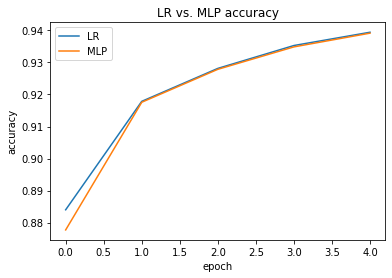

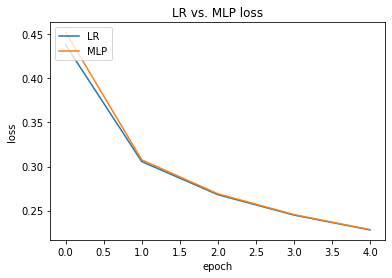

In [0]:
plt.plot(score_epoch)
plt.plot(score_epoch_mlp)
plt.title('LR vs. MLP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LR','MLP'], loc='upper left')
plt.show()

plt.plot(loss_epoch)
plt.plot(loss_epoch_mlp)
plt.title('LR vs. MLP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LR','MLP'], loc='upper left')
plt.show()

To conclude the section on Pytorch, both LR and MLP models performed well score-wise, but not better than MLP with SKLearn. Due to the complexity of implementing these models and the time cost of training, it is fair to say that overall, MLP with SKLearn performs better than LR and MLP with Pytorch.

It is also worth mentioning here that Pytorch is the reason for using only 10K samples of the dataset and not the full 42K sample size. With the MLP model taking over 2 hours to train with only 5 epochs and 10k samples, there was not enough time to wait for training to complete on the entire dataset. Futher on, we will demostrate training with the entire dataset with Tensorflow, but first, lets see how Tensorflow compares to SKlearn and Pytorch with the same training data. 

**4. Tensorflow**

To start with tensor flow, we have to import the tensorflow package and convert the data (currently stored as pandas dataframes) to lists.

In [2]:
import tensorflow as tf

In [0]:
images_train=X_train.values
labels_train=y_train.values

images_test=X_test.values
labels_test=y_test.values

**4a. LR with Tensor Flow**

Here we define the model for Linear Regression, with an input layer and an output layer. For this model we are using the adam optimizer and cross-entropy loss function.

In [0]:
modelLRtf = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax')
])

modelLRtf.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train the model with the train data. We are training with 50 epochs and a batch size of 500 samples. We are also using 1/3 of the data for validation, to measure how performance increases over epochs and track over-fitting.

In [0]:
model_lr_tf = modelLRtf.fit(images_train.reshape(-1,28,28), labels_train, validation_split=0.33, epochs=50, batch_size=500)


Train on 4689 samples, validate on 2311 samples
Epoch 1/50
4689/4689 [==============================] - 0s 97us/sample - loss: 2.1863 - acc: 0.2386 - val_loss: 1.9327 - val_acc: 0.4029
Epoch 2/50
4689/4689 [==============================] - 0s 24us/sample - loss: 1.7894 - acc: 0.5131 - val_loss: 1.5986 - val_acc: 0.6071
Epoch 3/50
4689/4689 [==============================] - 0s 26us/sample - loss: 1.4873 - acc: 0.6556 - val_loss: 1.3409 - val_acc: 0.7075
Epoch 4/50
4689/4689 [==============================] - 0s 24us/sample - loss: 1.2621 - acc: 0.7283 - val_loss: 1.1553 - val_acc: 0.7620
Epoch 5/50
4689/4689 [==============================] - 0s 26us/sample - loss: 1.0986 - acc: 0.7643 - val_loss: 1.0196 - val_acc: 0.7888
Epoch 6/50
4689/4689 [==============================] - 0s 25us/sample - loss: 0.9771 - acc: 0.7912 - val_loss: 0.9191 - val_acc: 0.8083
Epoch 7/50
4689/4689 [==============================] - 0s 27us/sample - loss: 0.8865 - acc: 0.8093 - val_loss: 0.8421 - val_acc: 

Calculate the average accuracy and validation accuracy over 50 epochs.



In [0]:
lr_tf_train_acc = sum(model_lr_tf.history['acc'])/len(model_lr_tf.history['acc'])
lr_tf_train_valacc = sum(model_lr_tf.history['val_acc'])/len(model_lr_tf.history['val_acc'])
print('Average acc: ',lr_tf_train_acc)
print('Average val_acc: ',lr_tf_train_valacc)

Average acc:  0.858831305205822
Average val_acc:  0.8568671590089798


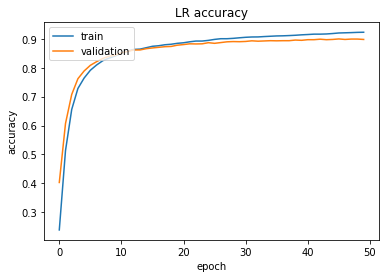

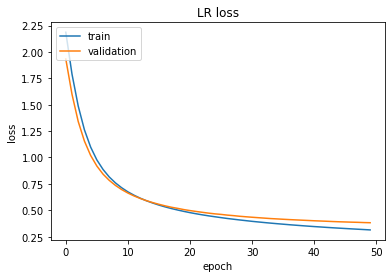

In [0]:
plt.plot(model_lr_tf.history['acc'])
plt.plot(model_lr_tf.history['val_acc'])
plt.title('LR accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(model_lr_tf.history['loss'])
plt.plot(model_lr_tf.history['val_loss'])
plt.title('LR loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

Linear regression with tensorflow performs well! The above graphs show that training accuracy/loss and validation accuracy/loss have very similar trends, suggesting that this model is not over-fitted to the training data. Next, lets compute the accuracy on the test data.

In [0]:
lr_tf_test = modelLRtf.evaluate(images_test.reshape(-1,28,28),  labels_test, verbose=2)

3000/3000 - 0s - loss: 0.3710 - acc: 0.8897


The accurcay on the test data for LR with tendorflow is ~89%, not quite as good as the score produced by the MLP model with SKLearn (94.7%). This model, however, was also very easy to implement and complied very quickly. With these promising results, next we will implement MLP with tensorflow.

**4b. MLP with Tensorflow**

Here we define the MLP model with 4 layers. 1 input layer, 2 hidden layers, and 1 output layer. We are still using Adam as the optimizer and cross-entropy as the loss function.

In [0]:
modelMLPtf = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

modelMLPtf.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train the model with 1/3 of the data for validation, 50 epochs, and batch size of 500 samples.

In [0]:
model_mlp_tf=modelMLPtf.fit(images_train.reshape(-1,28,28), labels, validation_split=0.33, epochs=50, batch_size=500)


Train on 4689 samples, validate on 2311 samples
Epoch 1/50
4689/4689 [==============================] - 1s 111us/sample - loss: 1.6328 - acc: 0.5138 - val_loss: 0.7323 - val_acc: 0.8256
Epoch 2/50
4689/4689 [==============================] - 0s 84us/sample - loss: 0.6676 - acc: 0.8012 - val_loss: 0.4178 - val_acc: 0.8771
Epoch 3/50
4689/4689 [==============================] - 0s 82us/sample - loss: 0.4541 - acc: 0.8539 - val_loss: 0.3532 - val_acc: 0.8992
Epoch 4/50
4689/4689 [==============================] - 0s 80us/sample - loss: 0.3598 - acc: 0.8912 - val_loss: 0.3064 - val_acc: 0.9087
Epoch 5/50
4689/4689 [==============================] - 0s 83us/sample - loss: 0.2957 - acc: 0.9128 - val_loss: 0.2851 - val_acc: 0.9143
Epoch 6/50
4689/4689 [==============================] - 0s 82us/sample - loss: 0.2486 - acc: 0.9260 - val_loss: 0.2662 - val_acc: 0.9186
Epoch 7/50
4689/4689 [==============================] - 0s 82us/sample - loss: 0.2085 - acc: 0.9388 - val_loss: 0.2627 - val_acc:

Calculate the average accuracy and validation accuracy over 50 epochs.



In [0]:
mlp_tf_train_acc = sum(model_mlp_tf.history['acc'])/len(model_mlp_tf.history['acc'])
mlp_tf_train_valacc = sum(model_mlp_tf.history['val_acc'])/len(model_mlp_tf.history['val_acc'])
print('Average acc: ',mlp_tf_train_acc)
print('Average val_acc: ',mlp_tf_train_valacc)

Average acc:  0.9700106608867646
Average val_acc:  0.9282907843589783


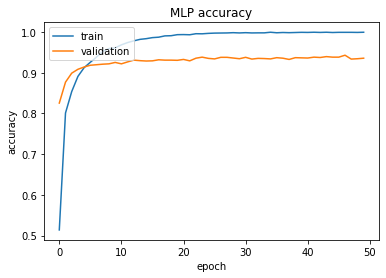

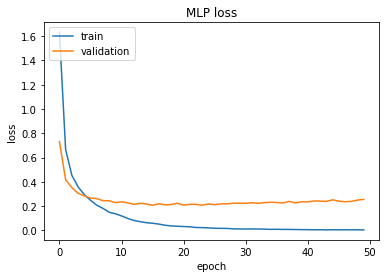

In [0]:
plt.plot(model_mlp_tf.history['acc'])
plt.plot(model_mlp_tf.history['val_acc'])
plt.title('MLP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(model_mlp_tf.history['loss'])
plt.plot(model_mlp_tf.history['val_loss'])
plt.title('MLP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

This model also performs well! The above graphs do represent evidence of over-fitting (by about ~4%). 

In [0]:
mlp_tf_test = modelMLPtf.evaluate(images_test.reshape(-1,28,28),  labels_test, verbose=2, batch_size=500)

3000/3000 - 0s - loss: 0.2259 - acc: 0.9423


The MLP model with tensorflow provided a test accuracy of 94.2%! 

**4c. Discussion**

The score for the MLP model with tensorflow is very similar to the score of the MLP model with SKLearn (94.7%) and about 6% better than the LR model with Tensorflow (88.97%). Since the results for the MLP models with Tensorflow and SKLearn are very similar, and they are both simple to implement and run quickly, it is worth it to compare these models again, but this time with the full 42k dataset.

**5. LR and MLP with more data**

Since both SKlearn and Tensorflow MLP models compiled very quickly and with similar results, we will try again with the entire dataset for 42000 samples instead of just 10000 samples to compare each performance.

**5a. Training models and getting results**

To start, we import and split the dataset using the same method as before, except we import the entire dataset instead of just 1000 samples.

In [8]:
#Read the dataset
train_tf = pd.read_csv("train.csv")
#Split features and labels
#X_tf = train.iloc[:10000, 1:]
#y_tf = train.iloc[:10000, 0]
X_tf = train_tf.iloc[:, 1:]
y_tf = train_tf.iloc[:, 0]
#Use train_test_split to split to train/test labels and train/test features. Train size = 70%, Test size = 30%
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y_tf, test_size = 0.3, random_state=1)
#Print sizes
print('Train features: ',X_train_tf.shape,', Train Labels: ',y_train_tf.shape)
print('Test features: ',X_test_tf.shape,', Test Labels: ',y_test_tf.shape)

Train features:  (29400, 784) , Train Labels:  (29400,)
Test features:  (12600, 784) , Test Labels:  (12600,)


In [0]:
#format the data
X_train_tf = X_train_tf.applymap(format_data)
X_test_tf = X_test_tf.applymap(format_data)

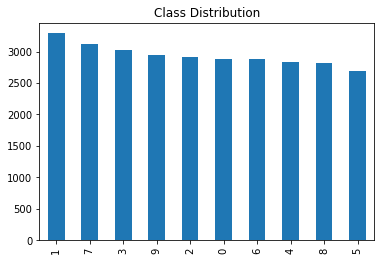

In [0]:
#Show distribution of each class
plt.figure() # Creates a new figure
y_train_tf.value_counts().plot(kind="bar", title="Class Distribution")
plt.show()

The class distribution is similar as the 10k sample from before, and fairly evenly distributed.

Now we train the MLP model with SKLearn.

In [0]:
#Import MLP
from sklearn.neural_network import MLPClassifier
model_skmlp_full=MLPClassifier(solver='adam',hidden_layer_sizes=350,alpha=1e-08)
#Train model
model_skmlp_full.fit(X_train_tf, y_train_tf)
#Print scores
print('Train score:',model_skmlp_full.score(X_train_tf,y_train_tf),', Test score:', model_skmlp_full.score(X_test_tf,y_test_tf))

Train score: 1.0 , Test score: 0.9746825396825397


The test score for MLP with SKLearn and the full dataset is 97.46%, about 3% higher than the score on the 10k dataset (94.7%). Now lets compare this score with LR and MLP models using tensorflow on the full dataset.

We create these models the same way they were created before. First, we convert the data into lists.

In [0]:
images_train_new=X_train_tf.values
labels_train_new=y_train_tf.values

images_test_new=X_test_tf.values
labels_test_new=y_test_tf.values

Train the new LR model.

In [0]:
#import tensorflow as tf
model_lr_tf_new = modelLRtf.fit(images_train_new.reshape(-1,28,28), labels_train_new, validation_split=0.33, epochs=50, batch_size=500)


Train on 19697 samples, validate on 9703 samples
Epoch 1/50
19697/19697 [==============================] - 1s 52us/sample - loss: 1.7320 - acc: 0.4983 - val_loss: 1.1953 - val_acc: 0.7419
Epoch 2/50
19697/19697 [==============================] - 1s 29us/sample - loss: 0.9715 - acc: 0.7860 - val_loss: 0.8116 - val_acc: 0.8202
Epoch 3/50
19697/19697 [==============================] - 1s 29us/sample - loss: 0.7229 - acc: 0.8336 - val_loss: 0.6580 - val_acc: 0.8478
Epoch 4/50
19697/19697 [==============================] - 1s 29us/sample - loss: 0.6074 - acc: 0.8533 - val_loss: 0.5746 - val_acc: 0.8620
Epoch 5/50
19697/19697 [==============================] - 1s 30us/sample - loss: 0.5384 - acc: 0.8665 - val_loss: 0.5216 - val_acc: 0.8732
Epoch 6/50
19697/19697 [==============================] - 1s 29us/sample - loss: 0.4921 - acc: 0.8763 - val_loss: 0.4849 - val_acc: 0.8791
Epoch 7/50
19697/19697 [==============================] - 1s 28us/sample - loss: 0.4584 - acc: 0.8825 - val_loss: 0.4

In [0]:
lr_tf_train_acc_new = sum(model_lr_tf_new.history['acc'])/len(model_lr_tf_new.history['acc'])
lr_tf_train_valacc_new = sum(model_lr_tf_new.history['val_acc'])/len(model_lr_tf_new.history['val_acc'])
print('Average acc: ',lr_tf_train_acc_new)
print('Average val_acc: ',lr_tf_train_valacc_new)

Average acc:  0.9022724294662475
Average val_acc:  0.8967906844615936


The train accuracy (90%) and the validation accuracy (89.6%) are higher than the model trained on 10k samples (both ~85%). We will compute the test accuracy with the MLP model.

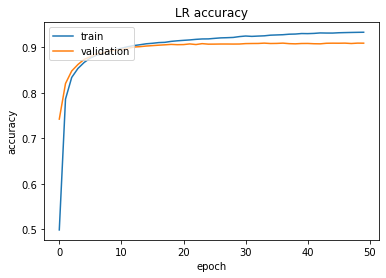

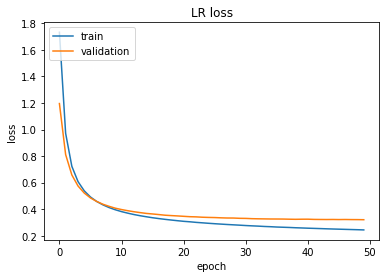

In [0]:
plt.plot(model_lr_tf_new.history['acc'])
plt.plot(model_lr_tf_new.history['val_acc'])
plt.title('LR accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(model_lr_tf_new.history['loss'])
plt.plot(model_lr_tf_new.history['val_loss'])
plt.title('LR loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

These graphs show a little over-fitting. We will compare with previous model further down.

In [17]:
model_mlp_tf_new=modelMLPtf.fit(images_test_new.reshape(-1,28,28), labels_test_new, validation_split=0.33, epochs=50, batch_size=500)


Train on 8442 samples, validate on 4158 samples
Epoch 1/50
8442/8442 [==============================] - 1s 101us/sample - loss: 1.2129 - acc: 0.6407 - val_loss: 0.4907 - val_acc: 0.8502
Epoch 2/50
8442/8442 [==============================] - 1s 80us/sample - loss: 0.4641 - acc: 0.8529 - val_loss: 0.3539 - val_acc: 0.8951
Epoch 3/50
8442/8442 [==============================] - 1s 79us/sample - loss: 0.3300 - acc: 0.9017 - val_loss: 0.2958 - val_acc: 0.9093
Epoch 4/50
8442/8442 [==============================] - 1s 80us/sample - loss: 0.2597 - acc: 0.9216 - val_loss: 0.2592 - val_acc: 0.9202
Epoch 5/50
8442/8442 [==============================] - 1s 80us/sample - loss: 0.2113 - acc: 0.9404 - val_loss: 0.2404 - val_acc: 0.9247
Epoch 6/50
8442/8442 [==============================] - 1s 81us/sample - loss: 0.1748 - acc: 0.9485 - val_loss: 0.2166 - val_acc: 0.9300
Epoch 7/50
8442/8442 [==============================] - 1s 81us/sample - loss: 0.1439 - acc: 0.9594 - val_loss: 0.2145 - val_acc:

In [0]:
mlp_tf_train_acc_new = sum(model_mlp_tf_new.history['acc'])/len(model_mlp_tf_new.history['acc'])
mlp_tf_train_valacc_new = sum(model_mlp_tf_new.history['val_acc'])/len(model_mlp_tf_new.history['val_acc'])
print('Average acc: ',mlp_tf_train_acc_new)
print('Average val_acc: ',mlp_tf_train_valacc_new)

Average acc:  0.9785406363010406
Average val_acc:  0.9421356427669525


The train accuracy (97.8%) and the validation accuracy (94.6%) are higher than the model trained on 10k samples (respectively 97% and 92.8%).

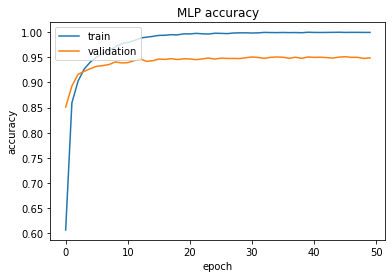

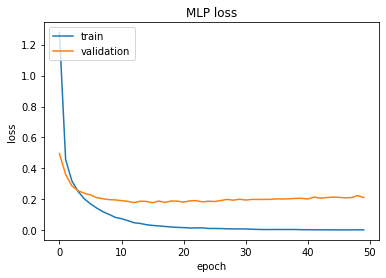

In [0]:
plt.plot(model_mlp_tf_new.history['acc'])
plt.plot(model_mlp_tf_new.history['val_acc'])
plt.title('MLP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(model_mlp_tf_new.history['loss'])
plt.plot(model_mlp_tf_new.history['val_loss'])
plt.title('MLP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

The above graphs do show evidence of over-fitting.

In [0]:
lr_tf_test_new = modelLRtf.evaluate(images_test_new.reshape(-1,28,28),  labels_test_new, verbose=2)

12600/12600 - 0s - loss: 0.2977 - acc: 0.9144


In [20]:
mlp_tf_test_new = modelMLPtf.evaluate(images_test_new.reshape(-1,28,28),  labels_test_new, verbose=2, batch_size=500)

12600/12600 - 0s - loss: 0.0673 - acc: 0.9841


The LR model produces an accuracy of 91.4% and the MLP model produces an accuracy of 98.41% on the test data.

**5b. Discussion**

First, we can compare the validation accuracy and loss of the 10k and the 42k models over 50 epochs.

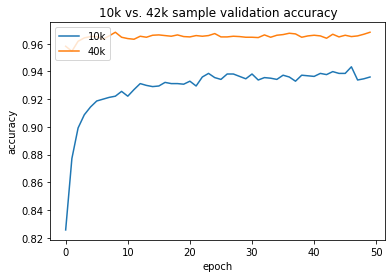

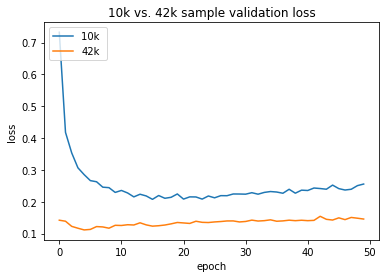

In [0]:
plt.plot(model_mlp_tf.history['val_acc'])
plt.plot(model_mlp_tf_new.history['val_acc'])
plt.title('10k vs. 42k sample validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['10k','40k'], loc='upper left')
plt.show()

plt.plot(model_mlp_tf.history['val_loss'])
plt.plot(model_mlp_tf_new.history['val_loss'])
plt.title('10k vs. 42k sample validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['10k ','42k'], loc='upper left')
plt.show()

The above graphs show that the 42k models perform quite a bit better in terms of accuracy and loss compared to the 10k models. 

In terms of test accuracy, the MLP model with SKLearn had an accuracy of 97.4%, the LR model with tensorflow had an accuracy of 91.4%, and the MLP model with tensorflow had an accuracy of 98.41%.

Thus, the MLP model with tensorflow performed the best out of all the models trained and tested on the enitre 42k dataset.

Let's take a look at the precision and recall for the model.

In [62]:
preds = modelMLPtf.predict(images_test_new.reshape(-1,28,28))
pred_labels = np.argmax(preds, axis=-1)
labels =labels_test_new

#initialize 0-array size 10 to track true positive, false positive, and false negative
#index represents class
tp = np.zeros((10)).astype(int)
fp = np.zeros((10)).astype(int)
fn = np.zeros((10)).astype(int)

recall_class = []
precision_class = []

for i in range(len(labels)):
  if(pred_labels[i]==labels[i]):
    tp[pred_labels[i]]+=1
  else:
    fp[pred_labels[i]]+=1
    fn[labels[i]]+=1

for i in range(10):
  precision_class.append(tp[i]/(tp[i]+fp[i]))
  recall_class.append(tp[i]/(tp[i]+fn[i]))

print(precision_class)
print(recall_class)


[0.984884645982498, 0.9921372408863474, 0.9927652733118971, 0.9855403348554034, 0.9744408945686901, 0.98359161349134, 0.9864972200158856, 0.9830246913580247, 0.9791164658634538, 0.9781729991915926]
[0.9927826784282278, 0.9949820788530466, 0.9824980111376292, 0.9803179409538229, 0.9902597402597403, 0.9711971197119712, 0.9872813990461049, 0.9914396887159533, 0.9759807846277022, 0.9718875502008032]


| Class          | Precision | Recall |
|-----------------|-----------------|-----------------|
| 0          | 98.48 %          | 99.27 %          |%
| 1          | 99.21 %          | 99.49 %          |%
| 2          | 99.27 %          | 98.24 %          |%
| 3          | 98.55 %          | 98.03 %          |%
| 4          | 97.44 %          | 99.02 %          |%
| 5          | 98.35 %          | 97.11 %          |%
| 6          | 98.64 %          | 98.72 %          |%
| 7          | 98.30 %          | 99.14 %          |%
| 8          | 97.91 %          | 97.59 %          |%
| 9          | 97.81 %          | 97.18 %          |%

**5. Discussion and Comparison of Results**

First, lets create a table to compare the train and test values of every model:

| Model          | Train Accuracy | Validation Accuracy | Test Accuracy |
|-----------------|-----------------|-----------------|-----------------|
| SKLearn LR          | 63.93 %          | -          | -593 %          |
| SKLearn (10k) MLP          | 100 %          | -          | 94.7 %          |%
| SKLearn (42k) MLP          | 100 %          | -          | 97.4 %          |%
| Pytorch LR          | 92.09 %          | -          | 90 %          |%
| Pytorch MLP          | 91.94 %          | -          | 94 %          |%
| Tensorflow (10k) LR          | 85.88 %          | 85.68 %          | 88.97 %          |%
| Tensorflow (10K) MLP          | 97 %          | 92.82 %          | 94.23 %          |%
| Tensorflow (42k) LR          | 92.4 %          | 90.85 %          | 91.49 %          |%
| Tensorflow (42k) MLP          | 97.85 %          | 94.21 %          | 98.41 %          |%     



With these results, it is easy to conclude that using a Multi-layer Perceptron model trained with the entire dataset using Tensorflow produces the best results at 98.41%. The two next best models were MLP with SKLearn on the full dataset, then on the 10k dataset. The worst performing model was Linear Regression with SKLearn, and the slowest models were MLP and LR with Pytorch respectively.

Therefore, the model and score that will be compared with the other two methods explored in this project (Naive Bayes and Convolutional Neural Network) is an MLP model created with tensorflow, with an accuracy of 98.41%.

**References**

1. https://www.geeksforgeeks.org/identifying-handwritten-digits-using-logistic-regression-pytorch/
2. https://github.com/iam-mhaseeb/Multi-Layer-Perceptron-MNIST-with-PyTorch/blob/master/mnist_mlp_exercise.ipynb
3. https://www.tensorflow.org/tutorials/quickstart/beginner
